In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 2023-05-12

@author: Henning Dorff
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Plotting routines

In [2]:
#import matplotlib
#import matplotlib.pyplot as plt
#import seaborn as sns
#matplotlib.rcParams.update({"font.size":16})    


In [3]:
# third hamp value shifted due to not working F-BAND module
flights=["RF05","RF06"]
ars_of_day=["AR_entire_1","AR_entire_2"]
campaign="HALO_AC3"
halo_icon_hmps={}
halo_icon_ivts={}
precip_rates={}
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sectors=["S1","S2","S3","S4"]
s=0
sector_sondes={}
for flight in flights:
    for ar_of_day in ars_of_day:
        sector_to_plot="warm"
        from simplified_flight_leg_handling import simplified_run_grid_main
        with HiddenPrints():
            halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,sector_sondes[sectors[s]]=\
            simplified_run_grid_main(flight=[flight],config_file_path=major_work_path,ar_of_day=ar_of_day)
        # ICON File
        icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
        hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
        icon_resolution=2000 # units m
        upsample_time="20min"
        date=flight_dates[flight]
        interp_icon_hmp_file=flight+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
        interp_icon_ivt_file=flight+"_"+ar_of_day+"_"+"ICON_Interpolated_IVT.csv"
        icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,[flight],ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

        ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
        cmpgn_cls,icon_var_list,halo_df,[flight],date,
        interpolated_hmp_file=interp_icon_hmp_file,
        interpolated_hmc_file=None,ar_of_day=ar_of_day,
        upsample_time=upsample_time,
        synthetic_icon=False,
        synthetic_flight=False)

        hydrometeor_icon_path=hydrometeor_icon_path+flight+"/"
        ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
        halo_icon_ivts[flight+"_"+ar_of_day]=pd.read_csv(hydrometeor_icon_path+interp_icon_ivt_file,index_col=0)
        halo_icon_ivts[flight+"_"+ar_of_day]["Sector"]=sectors[s]
        halo_icon_hmps[flight+"_"+ar_of_day]=ICON_on_HALO.load_interpolated_hmp()
        halo_icon_hmps[flight+"_"+ar_of_day]["Sector"]=sectors[s]
        #### cut dropsondes
        sector_sondes[sectors[s]]["IVT"]=sector_sondes[sectors[s]]["IVT"].loc[halo_icon_ivts[flight+"_"+ar_of_day].index[0]:\
                                                                halo_icon_ivts[flight+"_"+ar_of_day].index[-1]]
        sector_sondes[sectors[s]]["IWV"]=sector_sondes[sectors[s]]["IWV"].loc[halo_icon_ivts[flight+"_"+ar_of_day].index[0]:\
                                                                halo_icon_ivts[flight+"_"+ar_of_day].index[-1]]
        
        # read precip rates########
        rate_path =cmpgn_cls.campaign_path+"/data/precip_rates/"
        rate_fname=sector_to_plot+"_precip_"+flight+"_"+ar_of_day+".csv"
        precip_rates[flight+"_"+ar_of_day]=pd.read_csv(rate_path+rate_fname,index_col=0)
        precip_rates[flight+"_"+ar_of_day]["Sector"]=s+1
        if s==0:
            merged_precipitation=precip_rates[flight+"_"+ar_of_day]
        else:
            merged_precipitation=pd.concat([merged_precipitation,precip_rates[flight+"_"+ar_of_day]])
        
        ############
        s+=1
merged_rates         = pd.concat(precip_rates.values())
merged_halo_icon_hmp = pd.concat(halo_icon_hmps.values())
merged_halo_icon_ivt = pd.concat(halo_icon_ivts.values())

RF05_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
RF05_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened
RF06_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
RF06_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


In [4]:
### Allocate budget plotting classes

In [5]:
cmpgn_cls.plot_path=start_path+"/../plots/"
import Airborne_Budget_Plots as Airplots
haloac3_budget_plots = Airplots.HALO_AC3_Budget_Plots(cmpgn_cls,flight,ar_of_day)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/


In [6]:
precip_rates["RF05_AR_entire_1"]

,r_norris,r_palmer,r_chandra,s_schoger,s_matrosov,s_heymsfield,mean_snow,mean_rain,mean_unc,surface,precip_phase,mean_mixed,max_mixed,min_mixed,rate,Sector
2022-03-15 10:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,0.0,0.0,0.0,0.0,1
2022-03-15 10:11:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,0.0,0.0,0.0,0.0,1
2022-03-15 10:11:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,0.0,0.0,0.0,0.0,1
2022-03-15 10:11:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,0.0,0.0,0.0,0.0,1
2022-03-15 10:11:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15 13:15:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.985592,NaN,0.0,0.0,0.0,0.0,1
2022-03-15 13:15:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.985592,NaN,0.0,0.0,0.0,0.0,1
2022-03-15 13:15:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.985592,NaN,0.0,0.0,0.0,0.0,1
2022-03-15 13:15:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.985592,NaN,0.0,0.0,0.0,0.0,1


## AR decay

#### OLD Sonde and ICON intercomparison

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig10_HALO_RF05_RF06_IVT_tendency.pdf


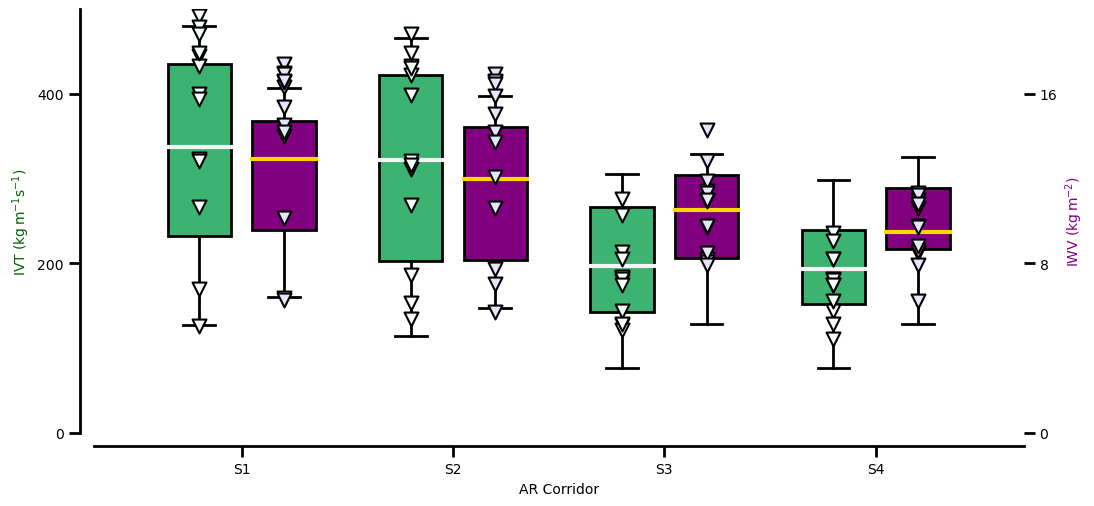

In [7]:
haloac3_budget_plots.plot_AR_intensity_boxplot_Sonde_ICON_single(merged_halo_icon_ivt,sector_sondes)

#### Sonde tendency in IWV and IVT

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig10_HALO_RF05_RF06_sonde_IWV_IVT_tendency.pdf


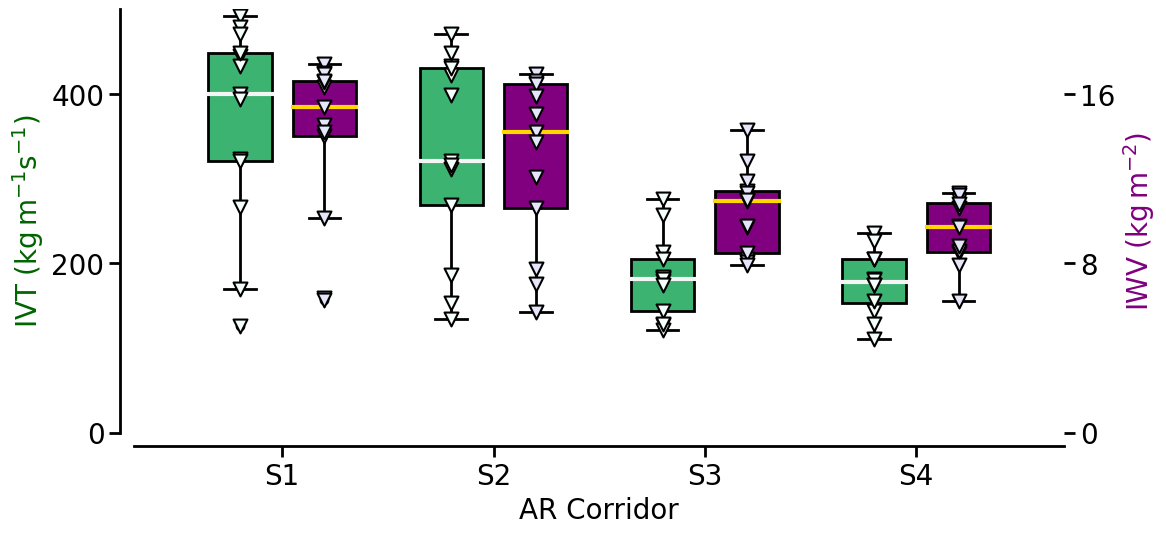

In [8]:
haloac3_budget_plots.plot_sonde_based_AR_intensity_boxplot(sector_sondes)

#### Boxplots for all four datasets (ICON and sonde-based IWV and IVT)

In [9]:
# ---> to be inserted with 
#haloac3_budget_plots.plot_AR_intensity_sonde_boxplots_with_icon(merged_halo_icon_ivt)

## Budget component values

In [10]:
haloac3_budget_plots.load_sector_budget_components()
budget_comps=haloac3_budget_plots.budget_df
budget_comps

,IWV_dt,IWV_dt_unc,ADV_q,ADV_q_unc,DIV_mass,DIV_mass_unc,Precip,Precip_min,Precip_max,Evap,Evap_unc
S1,-0.767738,0.211316,-0.278493,0.139154,-0.497346,0.056066,0.057032,0.014287,0.123682,0.007065,0.059248
S2,-0.193738,0.238721,-0.553945,0.172242,-0.539671,0.075791,0.041188,0.007473,0.103877,-0.006380,0.062227
S3,0.836216,0.165098,0.593545,0.140111,0.006555,0.094550,0.050191,0.013511,0.110727,0.056166,0.061512
S4,0.560422,0.090336,0.278702,0.380346,0.035408,0.105728,0.003945,0.001085,0.010733,0.089814,0.052798


## Residual

In [11]:
#d_IWV/dt=-nabla IVT + E - P + €
#€=d_IWV/dt+nabla IVT -E +P

residual_e=budget_comps["IWV_dt"]-budget_comps["ADV_q"]-budget_comps["DIV_mass"]-budget_comps["Evap"]+budget_comps["Precip"]
budget_comps["residual"]=residual_e
budget_comps["residual_unc"]=np.sqrt(budget_comps["IWV_dt_unc"]**2+budget_comps["DIV_mass_unc"]**2+\
        budget_comps["ADV_q_unc"]**2+(budget_comps["Precip_max"]-budget_comps["Precip_min"])**2)
haloac3_budget_plots.budget_df=budget_comps

### With Residuals

In [12]:
#with residuals
#plot_component_tendency(d_IWV_dt_hamp,d_IWV_dt_uncertainty,
#                            adv_q_series,mass_div_series,adv_q_unc,mass_div_unc,
#                            sector_precip,Evap_Sectors,with_residuals=residuals,with_boxplots=True)
# without residuals
#plot_component_tendency(d_IWV_dt_hamp,d_IWV_dt_uncertainty,
#                            adv_q_series,mass_div_series,adv_q_unc,mass_div_unc,
#                            sector_precip,Evap_Sectors,with_boxplots=False)

### Without Residuals

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig11_HALO_Budget_components_tendency.pdf


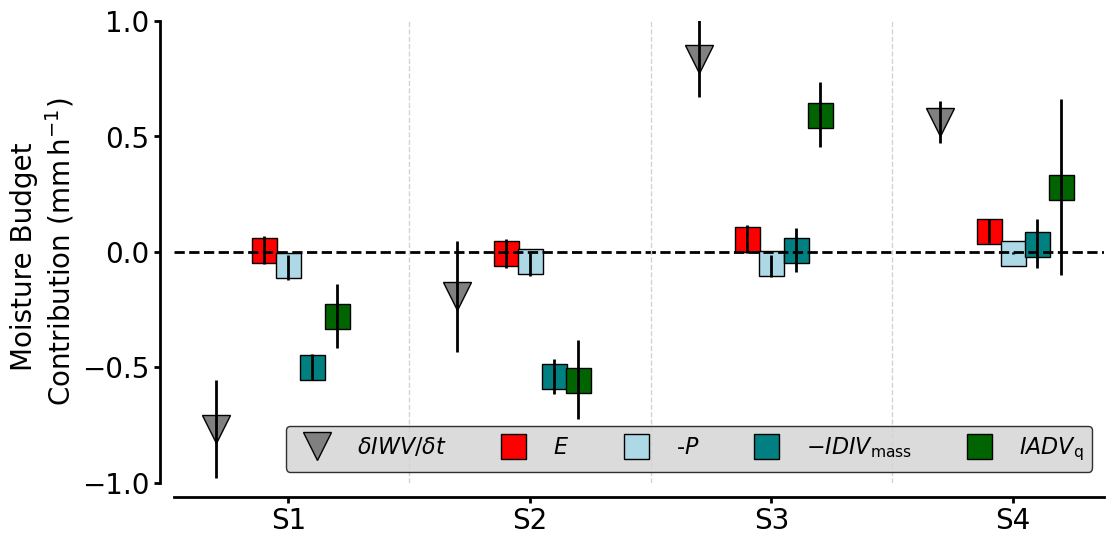

In [13]:
haloac3_budget_plots.updt_plot_component_tendency(save_as_manuscript_fig=True)

## Plot the residuals

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/Fig13_HALO_Budget_residual_tendency.pdf


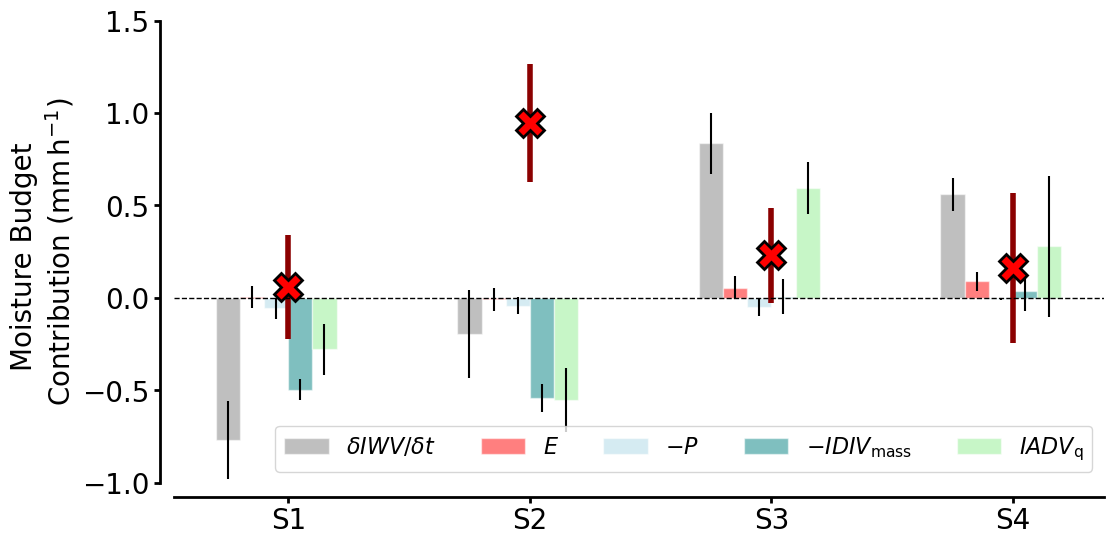

In [14]:
haloac3_budget_plots.plot_budget_residuals()

In [15]:
components={}
components["dIWV_dt"]     = d_IWV_dt_hamp
components["dIWV_dt_unc"] = d_IWV_dt_uncertainty
components["ADV"]         = adv_q_series
components["ADV_unc"]     = adv_q_unc
components["DIV"]         = mass_div_series
components["DIV_unc"]     = mass_div_unc
components["Precip"]      = sector_precip
components["Evap"]        = Evap_Sectors
plot_budget_residuals(residuals,components=components)

NameError: name 'd_IWV_dt_hamp' is not defined

# OLD values assignment

In [17]:
Evap_Sectors=pd.DataFrame(data=np.nan,columns=["mean","std"],index=sectors)
Evap_Sectors["mean"]=[0.002438,0.00275,-0.015,-0.0038]
Evap_Sectors["std"]=[0.006509,0.005,0.0083,0.0101]

scalar_based_div=False
warm_sonde_values={}
# List of uncertainties
#---------------------------------
#S1
# UNC adv  0.09904659648151819
# UNC mass 0.0390540623580486
#---------------------------------
#S2
# UNC adv  0.12255051592378231
# UNC mass 0.05330051908475317
#---------------------------------
#---------------------------------
#S4
# Old values before Readapting the divergence integrals
#warm_sonde_values["S1"]={'mass_div': 0.320,'mass_div_min': 0.056,'mass_div_max': 0.323,'mass_div_unc':0.05606615583661565,#0.0390540623580486,
#    'q_ADV': 0.162,'q_ADV_min': -0.42,'q_ADV_max': 0.74,'q_ADV_unc':0.13915442129379024 #now 400 meter correlation length 0.09904659648151819,}
#warm_sonde_values["S2"]={'mass_div': 0.369,'mass_div_min': -0.006,'mass_div_max': 0.378,'mass_div_unc': 0.07579105179504261,#0.0533,
#    'q_ADV': 0.309,'q_ADV_min': -0.328,'q_ADV_max': 0.946,'q_ADV_unc': 0.1722415822353062,#0.12255051592378231}    
#warm_sonde_values["S3"]={'mass_div': -0.01606136995913354,'mass_div_min': -0.07745809018313218,
#                         'mass_div_max': 0.14004981735327982,'mass_div_unc': 0.09455006318149353,#0.06758506711408048,
#                         'q_ADV': -0.4327365190866554,'q_ADV_min': -1.0441686154792087,
#                         'q_ADV_max': 0.1786,'q_ADV_unc': 0.14011083522506143#0.102958718959843}
# New values since April 2024
warm_sonde_values["S1"]={"mass_div":0.4973464302135367,"mass_div_unc":0.0560661,
                        "q_ADV":0.2784934068466571,"q_ADV_unc":0.139154}
warm_sonde_values["S2"]={"mass_div":0.53967107808,"mass_div_unc":0.075791,
                        "q_ADV":0.5539449535,"q_ADV_unc":0.172}
warm_sonde_values["S3"]={"mass_div":-0.006555078,"mass_div_unc":0.0945500,
                        "q_ADV":-0.593544551,"q_ADV_unc":0.1401108}
warm_sonde_values["S4"]={"mass_div":0.05900,"mass_div_unc":0.1057,
                        "q_ADV":-0.16035,"q_ADV_unc":0.380}
#UNC adv 0.2973193759560851
#UNC mass 0.08439010200621463
#warm_sonde_values["S4"]={'mass_div': -0.034578940690504,'mass_div_min': -0.1419551986643343,
#    'mass_div_max': 0.1648389618742725,'mass_div_unc': 0.10572761034063809,#0.08439010200621463,
#    'q_ADV': -0.1992739541087698,'q_ADV_min': -1.3204634891704425,
#    'q_ADV_max': 0.9219155809529028,'q_ADV_unc':0.38034635428879077#0.2973193759560851,}


In [18]:
# old values may 2023
#d_IWV_dt_sonde=pd.Series(data=[-0.25,-0.34,0.05,np.nan],index=["S1","S2","S3","S4"]) 
#d_IWV_dt_hamp=pd.Series(data=[-0.49,-0.31,0.66,np.nan],index=["S1","S2","S3","S4"]) 
d_IWV_dt_sonde=pd.Series(data=[-0.25,-0.34,0.05,np.nan],index=["S1","S2","S3","S4"]) 
d_IWV_dt_hamp=pd.Series(data=[-0.72,-0.19,0.66,0.56],index=["S1","S2","S3","S4"]) 
d_IWV_dt_uncertainty=pd.Series(data=[0.21,0.23872126958677942,0.30,0.3],index=["S1","S2","S3","S4"])

#budget_comps
#                       adv_q_unc.values**2+\
#                       #((mass_div_series_max-mass_div_series_min)/2)**2+\
#                       #((adv_q_series_max-adv_q_series_min)/2)**2+\
#                       ((sector_precip["max_rate"]-sector_precip["min_rate"])/2)**2+\
#                       Evap_Sectors["std"]**2)
#merge into dataframe
#residuals=pd.DataFrame(data=np.nan,index=residual_e.index,columns=["value","unc"])
#residuals["value"] = residual_e.values
#residuals["unc"]   = residual_e_unc.values

In [19]:
# scalar-based divergence values
if scalar_based_div:
    warm_sonde_values["S1"]={
      'mass_div': -0.41276886889204784,
      'mass_div_min': -0.7301260286358718,
      'mass_div_max': -0.09541170914822367,
      'q_ADV': -0.7907497132061316,
      'q_ADV_min': -1.565287488594897,
      'q_ADV_max': -0.016211937817365973}

    warm_sonde_values["S2"]={
        'mass_div': -0.1882352622233449,
        'mass_div_min': -0.6452538732851526,
        'mass_div_max': 0.2687833488384628,
        'q_ADV': -0.5474630545351018,
        'q_ADV_min': -1.3557554102823333,
        'q_ADV_max': 0.2608293012121298}

    warm_sonde_values["S3"]={
         'mass_div': -0.22776075016667244,
         'mass_div_min': -0.5096074494526325,
         'mass_div_max': 0.05408594911928759,
         'q_ADV': -0.7544264531963553,
         'q_ADV_min': -1.3814041637839345,
         'q_ADV_max': -0.12744874260877628}
    #    'mass_div': -0.23570411496183644,
    #    'mass_div_min': -0.602622062208785,
    #    'mass_div_max': 0.13121383228511205,
    #    'q_ADV': -0.7594541149453358,
    #    'q_ADV_min': -1.497718568202485,
    #    'q_ADV_max': -0.021189661688186773}

    warm_sonde_values["S4"]={
        'mass_div': -0.41276886889204784,
        'mass_div_min': 0.056,
        'mass_div_max': -0.09541170914822367,
        'q_ADV': -0.7907497132061316,
        'q_ADV_min': -1.565287488594897,
        'q_ADV_max': -0.016211937817365973}


In [20]:
merged_rates.index=pd.DatetimeIndex(merged_rates.index)
merged_rates=merged_rates.resample("10s").mean()

In [21]:
merged_precipitation["min_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].min(axis=1)
merged_precipitation["max_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].max(axis=1)
merged_precipitation["min_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].min(axis=1)
merged_precipitation["max_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].max(axis=1)
merged_precipitation["min_rate"]=merged_precipitation["min_rain"]+merged_precipitation["min_snow"]
merged_precipitation["max_rate"]=merged_precipitation["max_rain"]+merged_precipitation["max_snow"]

In [22]:
sector_precip=merged_precipitation.groupby("Sector").mean()
sector_precip.index=sectors
sector_precip

,r_norris,r_palmer,r_chandra,s_schoger,s_matrosov,s_heymsfield,mean_snow,mean_rain,mean_unc,surface,...,min_mixed,rate,lat,lon,min_rain,max_rain,min_snow,max_snow,min_rate,max_rate
S1,0.028619,0.052368,0.205312,0.002859,0.003896,0.034067,0.005598,0.036513,NaN,0.000000,...,0.000930,0.051790,75.028247,1.854305,0.028619,0.205329,0.002859,0.034067,NaN,NaN
S2,0.009601,0.019296,0.046928,0.000310,0.000406,0.008443,0.000041,0.010893,NaN,0.000000,...,0.002730,0.037786,74.245790,1.560051,0.009601,0.046963,0.000310,0.008443,NaN,NaN
S3,0.040950,0.073575,0.309428,0.031325,0.045683,0.090977,0.003064,0.034185,NaN,0.141109,...,0.000808,0.045627,72.641825,16.156601,0.040950,0.309455,0.031325,0.090977,NaN,NaN
S4,0.004189,0.008532,0.020064,0.005323,0.007498,0.036589,0.002003,0.000524,NaN,0.313925,...,0.000111,0.003679,75.278125,21.829058,0.004188,0.020264,0.005323,0.036589,NaN,NaN


In [23]:
sum_sector_precip=merged_precipitation.groupby("Sector").sum()
#sum_sector_precip["rate"]

In [24]:
adv_q_series        = pd.Series(data=[warm_sonde_values[sector]['q_ADV'] for sector in sectors],
                             index=sectors)
#adv_q_series_min    = pd.Series(data=[warm_sonde_values[sector]['q_ADV_min'] for sector in sectors],
#                             index=sectors)
#adv_q_series_max    = pd.Series(data=[warm_sonde_values[sector]['q_ADV_max'] for sector in sectors],
#                             index=sectors)
adv_q_unc           = pd.Series(data=[warm_sonde_values[sector]['q_ADV_unc'] for sector in sectors])
mass_div_series     = pd.Series(data=[warm_sonde_values[sector]['mass_div'] for sector in sectors],
                             index=sectors)
#mass_div_series_min = pd.Series(data=[warm_sonde_values[sector]['mass_div_min'] for sector in sectors],
#                             index=sectors)
#mass_div_series_max = pd.Series(data=[warm_sonde_values[sector]['mass_div_max'] for sector in sectors],
#                             index=sectors)
mass_div_unc        = pd.Series(data=[warm_sonde_values[sector]['mass_div_unc'] for sector in sectors])
#mass_div_unc

In [25]:
#d_IWV/dt=-nabla IVT + E - P + €
#€=d_IWV/dt+nabla IVT -E +P
residual_e=d_IWV_dt_hamp+adv_q_series.values+mass_div_series.values-Evap_Sectors["mean"]+sector_precip["rate"].values
residual_e_unc=np.sqrt(d_IWV_dt_uncertainty**2+\
                       mass_div_unc.values**2+\
                       adv_q_unc.values**2+\
                       #((mass_div_series_max-mass_div_series_min)/2)**2+\
                       #((adv_q_series_max-adv_q_series_min)/2)**2+\
                       ((sector_precip["max_rate"]-sector_precip["min_rate"])/2)**2+\
                       Evap_Sectors["std"]**2)
#merge into dataframe
residuals=pd.DataFrame(data=np.nan,index=residual_e.index,columns=["value","unc"])
residuals["value"] = residual_e.values
residuals["unc"]   = residual_e_unc.values

In [26]:
residuals

,value,unc
S1,0.105192,NaN
S2,0.938652,NaN
S3,0.120527,NaN
S4,0.466129,NaN
